### Burnin Steps determiantion

In [29]:
import numpy as np

N = 100
J = 1
KB = 1

n_temp, n_field = 3, 21
temps = [0.5, 2.269, 4.] # np.linspace(0.01,4.01,n_temp)
B_s = np.linspace(-2,2,n_field)

lattice_spins = np.ones((N, N))
burnin_up = 200_000
steps = 1_000_000


#Metropolis hating Algorithm
def MCMC(lattice_spins, temp, steps, B):
    m_values = []
    t = 0
    while t < steps:
        i, j = np.random.randint(N), np.random.randint(N)
        # we only need to consider the neighbors of 
        # (i, j) to calculate the change in energy
        delta_energy = 0
        for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
            i_neigh = i + k if i + k < N else 0
            j_neigh = j + l if j + l < N else 0
            delta_energy += ( (-J * -2 *  lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]) - (B * -2 * lattice_spins[i, j]) )
        if delta_energy <= 0:
            lattice_spins[i, j] *= -1
        elif delta_energy > 0:
            prob = np.exp(-delta_energy / (KB * temp))
            if np.random.random() < prob:
                lattice_spins[i, j] *= -1
        else: 
            continue
        m_values.append(np.mean(lattice_spins))
        t += 1
    return m_values


In [30]:
#initial configuration
lattice_spins = np.ones((N, N))
m_values_up = MCMC(lattice_spins, temps[2], steps, 1)

Text(0.5, 1.0, 'Magnetization vs steps')

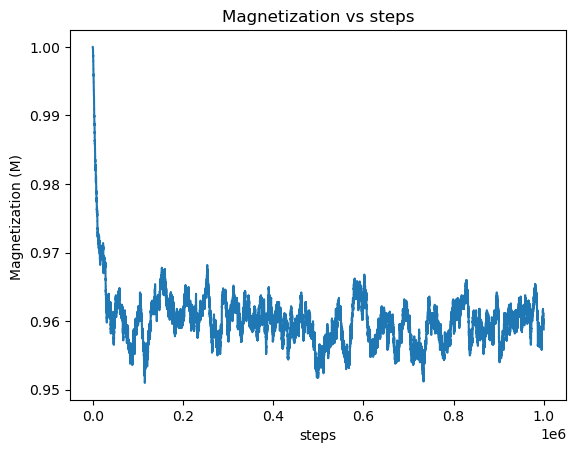

In [31]:
import matplotlib.pyplot as plt

plt.plot( np.linspace(0,steps,steps), m_values_up)
plt.xlabel("steps")
plt.ylabel("Magnetization (M) ")
plt.title("Magnetization vs steps")

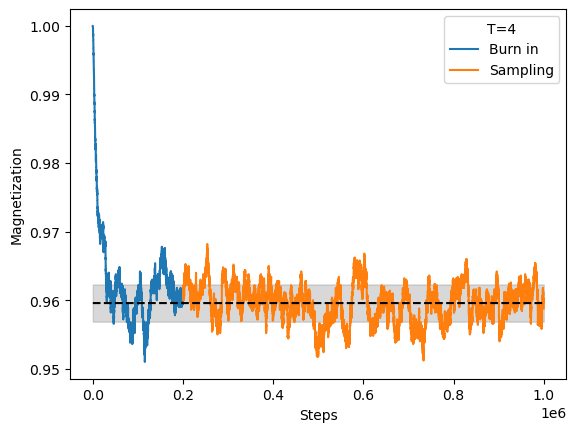

magnetization mean = 0.9595824219999998
magnetization std = 0.0027111722766943428


In [32]:
STEPS = 1_000_000
BURNIN = 200_000
m_mean = np.mean(m_values_up[BURNIN:])
m_std = np.std(m_values_up[BURNIN:])

plt.figure()
plt.plot(range(STEPS)[:BURNIN], m_values_up[:BURNIN], label="Burn in")
plt.plot(range(STEPS)[BURNIN:], m_values_up[BURNIN:], label="Sampling")
# show mean as dashed line
plt.plot(range(STEPS), m_mean * np.ones((STEPS)), "--", color="black")
# show variance as filled box
plt.fill_between(range(STEPS), m_mean - m_std, m_mean + m_std, color="gray", alpha=0.3)
plt.xlabel("Steps")
plt.ylabel("Magnetization")
plt.legend(title=f"T=4")
plt.show()

print(f"magnetization mean = {m_mean}")
print(f"magnetization std = {m_std}")

### Specific Heat computation

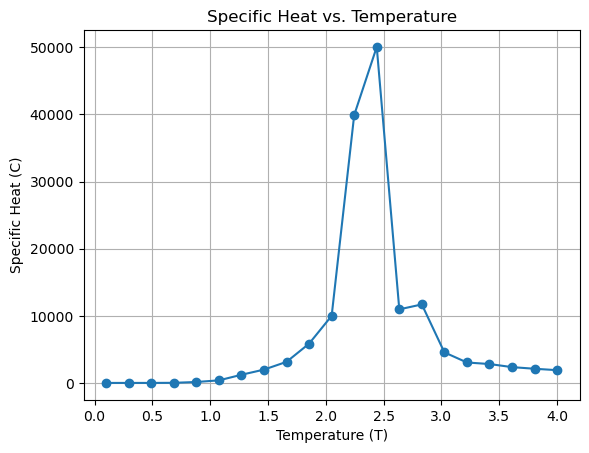

In [33]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
J = 1
KB = 1

n_temp, n_field = 3, 21
temps = np.linspace(0.1,4,21)
B_s = np.linspace(-2, 2, n_field)

lattice_spins = np.ones((N, N))
burnin_up = 200_000
steps = 1_000_000

#Same algorithm but with extra storage of Energy in each step
def MCMC(lattice_spins, temp, steps, B):
    energy_values = []
    t = 0
    while t < steps:
        i, j = np.random.randint(N), np.random.randint(N)
        delta_energy = 0
        for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
            i_neigh = i + k if i + k < N else 0
            j_neigh = j + l if j + l < N else 0
            delta_energy += (-J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]) - (B * -2 * lattice_spins[i, j])
        if delta_energy <= 0:
            lattice_spins[i, j] *= -1
        elif delta_energy > 0:
            prob = np.exp(-delta_energy / (KB * temp))
            if np.random.random() < prob:
                lattice_spins[i, j] *= -1
        energy = -J * np.sum(lattice_spins * (np.roll(lattice_spins, 1, axis=0) + np.roll(lattice_spins, 1, axis=1))) - (B * np.sum(lattice_spins))
        energy_values.append(energy)
        t += 1
    return energy_values

specific_heat = []

# Run the simulation for each temperature
for temp in temps:
    energy_values = MCMC(lattice_spins, temp, steps, B=0)  # Assuming B=0 for simplicity
    mean_energy = np.mean(energy_values)
    mean_energy_squared = np.mean(np.square(energy_values))
    specific_heat_value = (mean_energy_squared - mean_energy**2) / (KB * temp**2)
    specific_heat.append(specific_heat_value)

# Plot specific heat vs. temperature
plt.plot(temps, specific_heat, marker='o')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat (C)')
plt.title('Specific Heat vs. Temperature')
plt.grid(True)
plt.show()


### Critical Exponent by curve fittting and power function

In [ ]:
#We can use the curve fitting method we used in our assignemnt to find the component and critical temperature
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def power_law(T, Tc, alpha):
    return 1 / np.abs(T - Tc)**alpha

# Perform curve fitting to find Tc and alpha
initial_guess = [2.269,2.5]  # Initial guess for Tc and alpha
fit_params, _ = curve_fit(power_law, temps, specific_heat, p0=initial_guess)

# Extract Tc and alpha from the fit parameters
Tc_fit, alpha_fit = fit_params

# Plot the specific heat data and the fit
plt.plot(temps, specific_heat, marker='o', linestyle='', label='Data')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat (C)')
plt.title('Specific Heat vs. Temperature')

# Generate points for the fitted curve
fit_temps = np.linspace(min(temps), max(temps), 100)
fit_specific_heat = power_law(fit_temps, *fit_params)
plt.plot(fit_temps, fit_specific_heat, label=f'Fit: Tc={Tc_fit:.2f}, alpha={alpha_fit:.2f}')

plt.legend()
plt.grid(True)
plt.show()

print(f"Critical temperature (Tc): {Tc_fit}")
print(f"Critical exponent (alpha): {alpha_fit}")

### Conclusion slide Plot to show the effect of T and B in magnetization

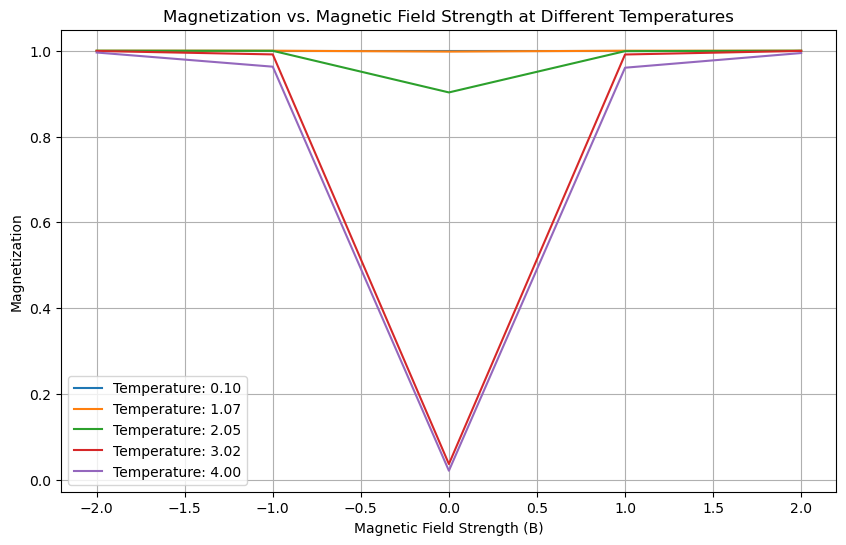

In [35]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
J = 1
KB = 1

n_temp, n_field = 3, 11
temps = np.linspace(0.1, 4, 5)
B_s = np.linspace(-2, 2, 5)

lattice_spins = np.ones((N, N))
burnin_up = 200_000
steps = 1_000_000

def MCMC(lattice_spins, temp, steps, B):
    magnetization_values = []
    t = 0
    while t < steps:
        i, j = np.random.randint(N), np.random.randint(N)
        delta_energy = 0
        for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:
            i_neigh = i + k if i + k < N else 0
            j_neigh = j + l if j + l < N else 0
            delta_energy += (-J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]) - (B * -2 *lattice_spins[i, j])
        if delta_energy <= 0:
            lattice_spins[i, j] *= -1
        elif delta_energy > 0:
            prob = np.exp(-delta_energy / (KB * temp))
            if np.random.random() < prob:
                lattice_spins[i, j] *= -1
        magnetization = np.abs(np.sum(lattice_spins)) / (N * N)
        magnetization_values.append(magnetization)
        t += 1
    return magnetization_values

# Perform simulations for different temperatures and magnetic fields
magnetization_data = []
for temp in temps:
    temp_magnetization = []
    for B in B_s:
        magnetization_values = MCMC(lattice_spins, temp, steps, B)
        temp_magnetization.append(magnetization_values[-1])
    magnetization_data.append(temp_magnetization)

# Plot magnetization as a function of temperature and magnetic field
plt.figure(figsize=(10, 6))
for i, temp in enumerate(temps):
    plt.plot(B_s, magnetization_data[i], label=f'Temperature: {temp:.2f}')
plt.xlabel('Magnetic Field Strength (B)')
plt.ylabel('Magnetization')
plt.title('Magnetization vs. Magnetic Field Strength at Different Temperatures')
plt.legend()
plt.grid(True)
plt.show()
